### V10: Fine-Tune DeBERTa-V3-Small 
- Train Data
- Down Sampling 'O' Label 0.30
- External Dataset 
- Evaluation Metric F-Beta5
- Cross Validation
- Max Length 2048
- No Stride

Trained on Kaggle with GPU T4 x2

Inference
- Max Length 4096
- No Stride
​
Leaderboard 
- Public Score: 0.957
- Private Score: 0.948

In [1]:
!pip install seqeval
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 712.0 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=700c2c669f189f0216815f2d5e3f1b3b28028fdab4c3922727d03fad65664b2e
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch

from datasets import Dataset
from functools import partial
from seqeval.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from tqdm import tqdm

2024-04-22 12:11:35.646475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 12:11:35.646633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 12:11:35.802308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class Setting:
    seed = 42
    base_dir = "/kaggle/input"

    # data
    data_train = f"{base_dir}/pii-train/train.json"
    data_nbroad = f"{base_dir}/pii-mistral/mixtral-8x7b-v1.json"
    data_valentinwerner = f"{base_dir}/pii-label-specific/all_labels.json"
    data_alejopaulier = f"{base_dir}/pii-fix-punctuation/pii_dataset_fixed.json"
    data_pjmathematician = f"{base_dir}/pii-fix-punctuation/moredata_dataset_fixed.json"
    data_minhsienweng = f"{base_dir}/pii-ai-generated/pii_dataset_Gemma.json"
    data_mandrilator = f"{base_dir}/pii-mistral/all_labels.json"
    
    down_sample_ratio = 0.30
    n_split = 5

    # model
    model_checkpoint = "microsoft/deberta-v3-small"
    model_train = '/kaggle/working/model/train'
    model_final = '/kaggle/working/model/final'
    max_length = 2048

    # hyperparameter
    epochs = 2
    learning_rate = 3e-5
    warmup_ratio = 0.1
    lr_scheduler_type='cosine'
    weight_decay = 0.01
    grad_steps = 2
    batch_size = 2

    # PII (NER) tags
    labels = ["B-EMAIL", "B-ID_NUM", "B-NAME_STUDENT", "B-PHONE_NUM",
              "B-STREET_ADDRESS", "B-URL_PERSONAL", "B-USERNAME",
              "I-ID_NUM", "I-NAME_STUDENT", "I-PHONE_NUM",
              "I-STREET_ADDRESS","I-URL_PERSONAL","O"]
    id2label = dict(enumerate(labels)) # integer label to BIO format label mapping
    label2id = {v:k for k,v in id2label.items()} # BIO format label to integer label mapping
    num_labels = len(labels) # number of PII (NER) tags

In [4]:
np.random.seed(Setting.seed)
torch.manual_seed(Setting.seed)

In [5]:
# read and combine all dataset
df_train = pd.read_json(Setting.data_train)
df_nbroad = pd.read_json(Setting.data_nbroad)
df_valentinwerner = pd.read_json(Setting.data_valentinwerner)
df_alejopaulier = pd.read_json(Setting.data_alejopaulier)
df_pjmathematician = pd.read_json(Setting.data_pjmathematician)
df_minhsienweng = pd.read_json(Setting.data_minhsienweng)
df_mandrilator = pd.read_json(Setting.data_mandrilator)

features = ['tokens', 'labels']
df = pd.concat([df_train[features],
                   df_nbroad[features],
                   df_valentinwerner[features],
                   df_alejopaulier[features],
                   df_pjmathematician[features],
                   df_minhsienweng[features],
                   df_mandrilator[features]],
                   ignore_index=True)

df = df[['tokens', 'labels']]
df.rename(columns={"labels": "pii_labels"}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      27442 non-null  object
 1   pii_labels  27442 non-null  object
dtypes: object(2)
memory usage: 428.9+ KB


In [6]:
def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column,
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    # show percentage on bar for first 3 bars
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)
    ax.get_legend().remove()
    plt.show()

def down_sample(df, down_sample_ratio, seed):
    df['non_pii_entity_only'] = df['pii_labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))

    df_non_pii_entity_only = df[df['non_pii_entity_only']].sample(frac=down_sample_ratio, random_state=seed)
    df_with_pii_entity = df[~df['non_pii_entity_only']]
    df = pd.concat([df_with_pii_entity, df_non_pii_entity_only])

    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())

    df.drop(columns=['non_pii_entity_only'], inplace=True)
    return df

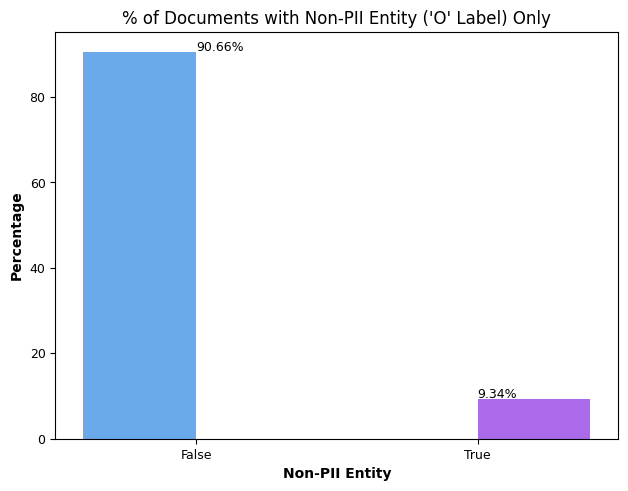

non_pii_entity_only
False    20430
True      2104
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22534 entries, 0 to 23091
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tokens      22534 non-null  object
 1   pii_labels  22534 non-null  object
dtypes: object(2)
memory usage: 528.1+ KB


In [7]:
df = down_sample(df, Setting.down_sample_ratio, Setting.seed)
df.info()

In [8]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['tokens', 'pii_labels', '__index_level_0__'],
    num_rows: 22534
})

In [9]:
def tokenize_and_align_labels(examples, tokenizer, label2id, max_length):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, max_length=max_length, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["pii_labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.       
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [10]:
def compute_metrics(p, id2label):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    report = classification_report(y_true=true_labels, y_pred=true_predictions, output_dict=True)
    micro_avg = report.pop("micro avg")    
    
    precision = micro_avg["precision"]
    recall = micro_avg["recall"]
    beta = 5
    fbeta = ((1+(beta**2))*precision*recall) / ((beta**2)*precision + recall)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": micro_avg["f1-score"],
        "fb-5": fbeta
    }

In [11]:
folds = [
    (
        np.array([i for i, d in enumerate(ds["pii_labels"]) if i % Setting.n_split != s]),
        np.array([i for i, d in enumerate(ds["pii_labels"]) if i % Setting.n_split == s])
    )
    for s in tqdm(range(Setting.n_split))
]

100%|██████████| 5/5 [02:29<00:00, 29.91s/it]


In [12]:
gc.collect()
torch.cuda.empty_cache()
time.sleep(10)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint, add_prefix_space=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    per_device_eval_batch_size=Setting.batch_size,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    logging_steps=10,
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):        
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length
                                                    }, 
                                         batched=True)
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels'])
    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length
                                                }, 
                                     batched=True)
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels'])
    
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    print('------------------------------------------------------')

Fold: 0, train_ds: 18027, val_ds:  4507


Map:   0%|          | 0/18027 [00:00<?, ? examples/s]

Map:   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 0, tokenized_train_ds: 18027, tokenized_val_ds:  4507


Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.007500,0.008340,0.955940,0.892964,0.923380,0.895233
1,0.002900,0.007203,0.936750,0.927790,0.932248,0.928131


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/kaggle/working/model/train/checkpoint-4506
------------------------------------------------------
Fold: 1, train_ds: 18027, val_ds:  4507


Map:   0%|          | 0/18027 [00:00<?, ? examples/s]

Map:   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 1, tokenized_train_ds: 18027, tokenized_val_ds:  4507


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


In [13]:
import shutil

In [14]:
# Training crashed at fold #1, retrain from checkpoing /kaggle/working/model/train/checkpoint-4506
Setting.model_checkpoint = '/kaggle/input/pii-data-with-deberta-v3-small/model/train/checkpoint-4506'
print(Setting.model_checkpoint)

tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint, add_prefix_space=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    per_device_eval_batch_size=1,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    logging_steps=100,
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):
    if fold_idx < 1:
        # skip fold 0
        continue
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length
                                                    }, 
                                         batched=True)
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels'])
    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length
                                                }, 
                                     batched=True)
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels'])
    
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)
    shutil.make_archive('model_final', 'zip', Setting.model_final)
    shutil.make_archive('best_model_checkpoint', 'zip', ng.model_checkpoint)
    print('------------------------------------------------------')

/kaggle/input/pii-data-with-deberta-v3-small/model/train/checkpoint-4506
Fold: 1, train_ds: 18027, val_ds:  4507


Map:   0%|          | 0/18027 [00:00<?, ? examples/s]

Map:   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 1, tokenized_train_ds: 18027, tokenized_val_ds:  4507


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.006400,0.007063,0.924102,0.902748,0.913300,0.903551
1,0.004700,0.005547,0.953396,0.927130,0.940080,0.928113


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/kaggle/working/model/train/checkpoint-4506


NameError: name 'trainer' is not defined

In [16]:
shutil.make_archive('model_final_1', 'zip', Setting.model_final)
shutil.make_archive('checkpoint-4506', 'zip', Setting.model_checkpoint)

'/kaggle/working/checkpoint-4506.zip'

In [17]:
print(Setting.model_checkpoint)

/kaggle/working/model/train/checkpoint-4506


In [19]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint, add_prefix_space=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    per_device_eval_batch_size=1,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    logging_steps=100,
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):
    if fold_idx < 2:
        # skip fold 0 and 1
        continue
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length
                                                    }, 
                                         batched=True)
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels'])
    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length
                                                }, 
                                     batched=True)
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels'])
    
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)
    shutil.make_archive(f'model_final_{fold_idx}', 'zip', Setting.model_final)
    shutil.make_archive(f'best_model_checkpoint_{fold_idx}', 'zip', Setting.model_checkpoint)
    print('------------------------------------------------------')

Fold: 2, train_ds: 18027, val_ds:  4507


Map:   0%|          | 0/18027 [00:00<?, ? examples/s]

Map:   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 2, tokenized_train_ds: 18027, tokenized_val_ds:  4507


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.006900,0.005764,0.969645,0.915381,0.941732,0.917356
1,0.003100,0.005110,0.960509,0.938333,0.949291,0.939167


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/kaggle/working/model/train/checkpoint-4506


NameError: name 'ng' is not defined

In [20]:
tokenizer = AutoTokenizer.from_pretrained(Setting.model_checkpoint, add_prefix_space=True)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=Setting.model_train,
    num_train_epochs=Setting.epochs,
    learning_rate=Setting.learning_rate,
    lr_scheduler_type=Setting.lr_scheduler_type,
    warmup_ratio=Setting.warmup_ratio,
    weight_decay=Setting.weight_decay,
    gradient_accumulation_steps=Setting.grad_steps,
    per_device_train_batch_size=Setting.batch_size,
    per_device_eval_batch_size=1,
    seed=Setting.seed,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="fb-5",
    logging_steps=100,
    greater_is_better=True,
    load_best_model_at_end=True
)

for fold_idx, (train_idx, val_idx) in enumerate(folds):
    if fold_idx < 3:
        # skip fold 0 to 2
        continue
    train_ds = ds.select(train_idx)
    val_ds = ds.select(val_idx)
    print(f'Fold: {fold_idx}, train_ds: {train_ds.num_rows}, val_ds:  {val_ds.num_rows}')    
    tokenized_train_ds = train_ds.map(tokenize_and_align_labels, 
                                         fn_kwargs={"tokenizer": tokenizer, 
                                                     "label2id": Setting.label2id, 
                                                     "max_length": Setting.max_length
                                                    }, 
                                         batched=True)
    tokenized_train_ds = tokenized_train_ds.remove_columns(['tokens', 'pii_labels'])
    
    tokenized_val_ds = val_ds.map(tokenize_and_align_labels, 
                                     fn_kwargs={"tokenizer": tokenizer, 
                                                 "label2id": Setting.label2id, 
                                                 "max_length": Setting.max_length
                                                }, 
                                     batched=True)
    tokenized_val_ds = tokenized_val_ds.remove_columns(['tokens', 'pii_labels'])
    
    print(f'Fold: {fold_idx}, tokenized_train_ds: {tokenized_train_ds.num_rows}, tokenized_val_ds:  {tokenized_val_ds.num_rows}') 
    
    model = AutoModelForTokenClassification.from_pretrained(
        Setting.model_checkpoint, 
        num_labels=Setting.num_labels, 
        id2label=Setting.id2label, 
        label2id=Setting.label2id
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_ds,
        eval_dataset=tokenized_val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, id2label=Setting.id2label)
    )
    
    trainer.train()
    # set best model checkpoint
    Setting.model_checkpoint = trainer.state.best_model_checkpoint
    print(Setting.model_checkpoint)
    trainer.save_model(Setting.model_final)
    tokenizer.save_pretrained(Setting.model_final)

    del trainer
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)
    shutil.make_archive(f'model_final_{fold_idx}', 'zip', Setting.model_final)
    shutil.make_archive(f'best_model_checkpoint_{fold_idx}', 'zip', Setting.model_checkpoint)
    print('------------------------------------------------------')

Fold: 3, train_ds: 18027, val_ds:  4507


Map:   0%|          | 0/18027 [00:00<?, ? examples/s]

Map:   0%|          | 0/4507 [00:00<?, ? examples/s]

Fold: 3, tokenized_train_ds: 18027, tokenized_val_ds:  4507


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.004600,0.004575,0.969520,0.932434,0.950615,0.933808
1,0.002900,0.003831,0.968108,0.943906,0.955854,0.944814


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/kaggle/working/model/train/checkpoint-4506
------------------------------------------------------
Fold: 4, train_ds: 18028, val_ds:  4506


Map:   0%|          | 0/18028 [00:00<?, ? examples/s]

Map:   0%|          | 0/4506 [00:00<?, ? examples/s]

Fold: 4, tokenized_train_ds: 18028, tokenized_val_ds:  4506


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Fb-5
0,0.003600,0.004316,0.936411,0.970269,0.953039,0.968921
1,0.002900,0.003076,0.974843,0.956807,0.965741,0.957488


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/kaggle/working/model/train/checkpoint-2253
------------------------------------------------------
